In [18]:
import os
from os import path
import json
import sys
from collections import defaultdict

import numpy as np
import seaborn as sns
sys.path.append("/home/shtoshni/Research/events/src/")
from kbp_2015_utils.constants import EVENT_SUBTYPES


# from red_utils.constants import IDX_TO_ELEM_TYPE

In [19]:
input_file = "/home/shtoshni/Research/events/models/events_kbp_2015_4eaa5896f60608d2a5179f58e52ed873/dev.log.jsonl"


### Check Multitagging

In [20]:
multitag_gt_spans = 0
multitag_pred_spans = 0

def get_multitag_spans(clusters):
    span_boundary_to_type = dict()
    multitag_counter = 0
    for cluster in clusters:
        for span_start, span_end, event_subtype in cluster:
            if (span_start, span_end) in span_boundary_to_type:
                multitag_counter += 1
            else:
                span_boundary_to_type[(span_start, span_end)] = event_subtype
    return multitag_counter


with open(input_file) as f:
    for line in f:
        instance = json.loads(line.strip())
        
        multitag_gt_spans += get_multitag_spans(instance["clusters"])
        multitag_pred_spans += get_multitag_spans(instance["predicted_clusters"])
                
print(f"Multitag GT Spans: {multitag_gt_spans}, Multitag Pred Spans: {multitag_pred_spans}")

Multitag GT Spans: 62, Multitag Pred Spans: 59


In [21]:
def get_mentions(clusters):
    span_dict = defaultdict(set)
    mentions = set()
    for cluster in clusters:
        for span_start, span_end, event_subtype in cluster:
            if isinstance(event_subtype, dict):
                event_subtype = event_subtype['subtype_val']
            span_dict[(span_start, span_end)].add(event_subtype)
            mentions.add((span_start, span_end, event_subtype))
            
    return span_dict, mentions

### Dissect Mention Detection Performance and Confusion Matrix

In [22]:
conf_counts = np.zeros((len(EVENT_SUBTYPES), len(EVENT_SUBTYPES)))

event_type_gt = [0] * len(EVENT_SUBTYPES)
event_type_pred = [0] * len(EVENT_SUBTYPES)
event_type_corr = [0] * len(EVENT_SUBTYPES)


with open(input_file) as f:
    for line in f:
        instance = json.loads(line.strip())
        
        gt_span_dict, gt_mentions = get_mentions(instance["clusters"])
        pred_span_dict, pred_mentions = get_mentions(instance["predicted_clusters"])
        
        common_spans = set(pred_span_dict.keys()).intersection(set(pred_span_dict.keys()))
        
        for span in common_spans:
            gt_event_subtypes = gt_span_dict[span]
            pred_event_subtypes = pred_span_dict[span]
            
            for gs in gt_event_subtypes:
                for ps in pred_event_subtypes:
                    conf_counts[gs, ps] += 1
            
        for mention in gt_mentions:
            event_type_gt[mention[2]] += 1
        
        for mention in pred_mentions:
            event_type_pred[mention[2]] += 1
        
        for mention in gt_mentions.intersection(pred_mentions):
            event_type_corr[mention[2]] += 1
            

conf_counts = conf_counts/(np.sum(conf_counts, axis=1) + 1e-8)
        

In [23]:
from tabulate import tabulate

data = []
for idx, event_subtype in enumerate(EVENT_SUBTYPES):
    prec = 100 * event_type_corr[idx]/(event_type_pred[idx] + 1e-8)
    recall = 100 * event_type_corr[idx]/(event_type_gt[idx] + 1e-8)
    f_score = 2 * prec * recall / (prec + recall + 1e-8)
    data.append([event_subtype, round(f_score, 2), round(prec, 2), round(recall, 2),  
                event_type_gt[idx], event_type_pred[idx]])
    

all_gold = sum(event_type_gt)
all_preds = sum(event_type_pred)
all_corr = sum(event_type_corr)
prec = 100 * all_corr/(all_preds + 1e-8)
recall = 100 * all_corr/(all_gold + 1e-8)
f_score = 2 * prec * recall / (prec + recall + 1e-8)
data.append(["All", round(f_score, 2), round(prec, 2), round(recall, 2), all_gold, all_preds])
    
print(tabulate(data, headers=["Event Subtype", "F", "P", "R",  "#Gold", "#Sys"]))
#     print (f"{event_subtype}\t\t\t{round(prec, 2)}\t{round(recall, 2)}\t{round(f_score, 2)}")
    


Event Subtype                       F       P       R    #Gold    #Sys
-----------------------------  ------  ------  ------  -------  ------
business_declarebankruptcy       0       0       0           0      12
business_endorg                  0       0       0           2       0
business_mergeorg              100     100     100           1       1
business_startorg               71.43   62.5    83.33        6       8
conflict_attack                 70.69   78.52   64.29      182     149
conflict_demonstrate            95.65  100      91.67       12      11
contact_broadcast               37.29   40.74   34.37       64      54
contact_contact                 32.56   32.31   32.81       64      65
contact_correspondence          48.98   66.67   38.71       31      18
contact_meet                    50.47   50.94   50          54      53
justice_acquit                  62.5   100      45.45       11       5
justice_appeal                 100     100     100           1       1
justic

<AxesSubplot:>

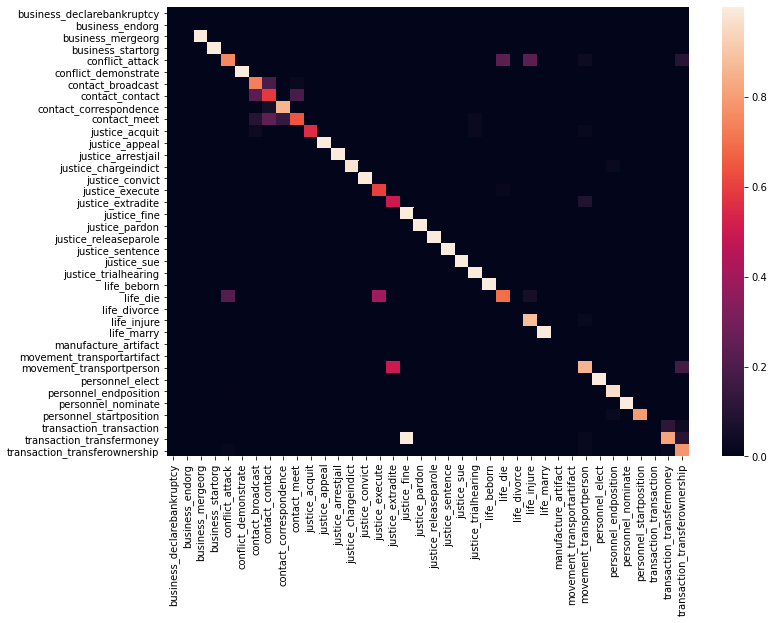

In [24]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

sns.heatmap(conf_counts, xticklabels=EVENT_SUBTYPES, yticklabels=EVENT_SUBTYPES, cbar=True)#, cmap="YlGnBu")